<a href="https://colab.research.google.com/github/elichen/oai-playground/blob/main/Using_GPT4_Vision_with_Function_Calling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
%pip install openai instructor pymupdf jsonref --quiet

In [5]:
from google.colab import userdata
from openai import OpenAI
client = OpenAI(api_key=userdata.get('openai-key'))

In [10]:
import requests, os

URL_PREFIX = "https://raw.githubusercontent.com/openai/openai-cookbook/main/examples/multimodal/images/"
files = [
    "damaged_package.jpg",
    "normal_package.jpg",
    "wet_package.jpg"
]

os.makedirs("images", exist_ok=True)

for file_name in files:
    try:
        with open(os.path.join("images", file_name), 'wb') as f:
            f.write(requests.get(URL_PREFIX + file_name).content)
    except:
        pass

In [12]:
import base64
import os
from enum import Enum
from io import BytesIO
from typing import Iterable
from typing import List
from typing import Literal, Optional

import fitz
# Instructor is powered by Pydantic, which is powered by type hints. Schema validation, prompting is controlled by type annotations
import instructor
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
from PIL import Image
from pydantic import BaseModel, Field

Encoded image: wet_package.jpg
Encoded image: normal_package.jpg
Encoded image: damaged_package.jpg


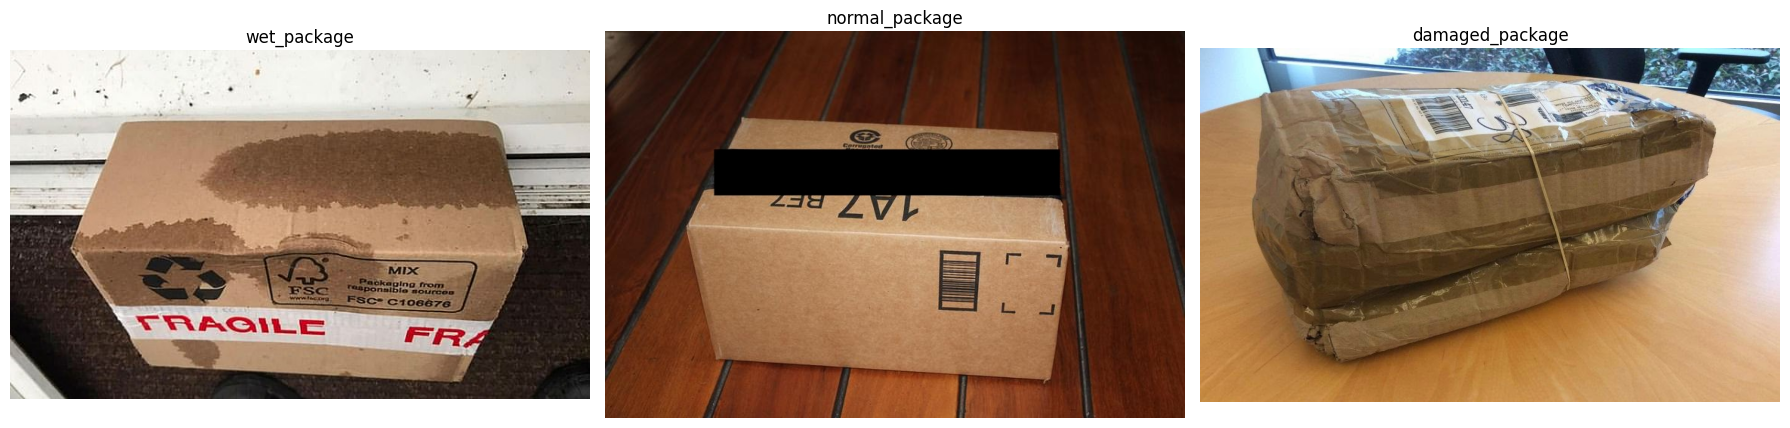

In [13]:
# Function to encode the image as base64
def encode_image(image_path: str):
    # check if the image exists
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file not found: {image_path}")
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')


# Sample images for testing
image_dir = "images"

# encode all images within the directory
image_files = os.listdir(image_dir)
image_data = {}
for image_file in image_files:
    image_path = os.path.join(image_dir, image_file)
    # encode the image with key as the image file name
    image_data[image_file.split('.')[0]] = encode_image(image_path)
    print(f"Encoded image: {image_file}")


def display_images(image_data: dict):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    for i, (key, value) in enumerate(image_data.items()):
        img = Image.open(BytesIO(base64.b64decode(value)))
        ax = axs[i]
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(key)
    plt.tight_layout()
    plt.show()


display_images(image_data)

In [14]:
MODEL = "gpt-4-turbo-2024-04-09"

class Order(BaseModel):
    """Represents an order with details such as order ID, customer name, product name, price, status, and delivery date."""
    order_id: str = Field(..., description="The unique identifier of the order")
    product_name: str = Field(..., description="The name of the product")
    price: float = Field(..., description="The price of the product")
    status: str = Field(..., description="The status of the order")
    delivery_date: str = Field(..., description="The delivery date of the order")
# Placeholder functions for order processing

def get_order_details(order_id):
    # Placeholder function to retrieve order details based on the order ID
    return Order(
        order_id=order_id,
        product_name="Product X",
        price=100.0,
        status="Delivered",
        delivery_date="2024-04-10",
    )

def escalate_to_agent(order: Order, message: str):
    # Placeholder function to escalate the order to a human agent
    return f"Order {order.order_id} has been escalated to an agent with message: `{message}`"

def refund_order(order: Order):
    # Placeholder function to process a refund for the order
    return f"Order {order.order_id} has been refunded successfully."

def replace_order(order: Order):
    # Placeholder function to replace the order with a new one
    return f"Order {order.order_id} has been replaced with a new order."

class FunctionCallBase(BaseModel):
    rationale: Optional[str] = Field(..., description="The reason for the action.")
    image_description: Optional[str] = Field(
        ..., description="The detailed description of the package image."
    )
    action: Literal["escalate_to_agent", "replace_order", "refund_order"]
    message: Optional[str] = Field(
        ...,
        description="The message to be escalated to the agent if action is escalate_to_agent",
    )
    # Placeholder functions to process the action based on the order ID
    def __call__(self, order_id):
        order: Order = get_order_details(order_id=order_id)
        if self.action == "escalate_to_agent":
            return escalate_to_agent(order, self.message)
        if self.action == "replace_order":
            return replace_order(order)
        if self.action == "refund_order":
            return refund_order(order)

class EscalateToAgent(FunctionCallBase):
    """Escalate to an agent for further assistance."""
    pass

class OrderActionBase(FunctionCallBase):
    pass

class ReplaceOrder(OrderActionBase):
    """Tool call to replace an order."""
    pass

class RefundOrder(OrderActionBase):
    """Tool call to refund an order."""
    pass

In [16]:
# extract the tool call from the response
ORDER_ID = "12345"  # Placeholder order ID for testing
INSTRUCTION_PROMPT = "You are a customer service assistant for a delivery service, equipped to analyze images of packages. If a package appears damaged in the image, automatically process a refund according to policy. If the package looks wet, initiate a replacement. If the package appears normal and not damaged, escalate to agent. For any other issues or unclear images, escalate to agent. You must always use tools!"

def delivery_exception_support_handler(test_image: str):
    payload = {
        "model": MODEL,
        "response_model": Iterable[RefundOrder | ReplaceOrder | EscalateToAgent],
        "tool_choice": "auto",  # automatically select the tool based on the context
        "temperature": 0.0,  # for less diversity in responses
        "seed": 123,  # Set a seed for reproducibility
    }
    payload["messages"] = [
        {
            "role": "user",
            "content": INSTRUCTION_PROMPT,
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{image_data[test_image]}"
                    }
                },
            ],
        }
    ]
    function_calls = instructor.from_openai(
        client, mode=instructor.Mode.PARALLEL_TOOLS
    ).chat.completions.create(**payload)
    for tool in function_calls:
        print(f"- Tool call: {tool.action} for provided img: {test_image}")
        print(f"- Parameters: {tool}")
        print(f">> Action result: {tool(ORDER_ID)}")
        return tool


print("Processing delivery exception support for different package images...")

print("\n===================== Simulating user message 1 =====================")
assert delivery_exception_support_handler("damaged_package").action == "refund_order"

print("\n===================== Simulating user message 2 =====================")
assert delivery_exception_support_handler("normal_package").action == "escalate_to_agent"

print("\n===================== Simulating user message 3 =====================")
assert delivery_exception_support_handler("wet_package").action == "replace_order"

Processing delivery exception support for different package images...

===================== Simulating user message 1 =====================
- Tool call: refund_order for provided img: damaged_package
- Parameters: rationale='The package is visibly damaged with significant tears and crushing, indicating that the contents may also be compromised.' image_description='The package in the image shows extensive damage, including deep creases and tears in the packaging material. The package appears crushed on multiple sides, suggesting rough handling during transit.' action='refund_order' message=None
>> Action result: Order 12345 has been refunded successfully.

===================== Simulating user message 2 =====================
- Tool call: escalate_to_agent for provided img: normal_package
- Parameters: rationale='The package appears normal and not damaged, requiring further assistance for any potential issues not visible in the image.' image_description='A cardboard package on a wooden 

In [17]:
def download_file(url, save_dir="."):
    os.makedirs(save_dir, exist_ok=True)
    file_name = os.path.basename(url)
    try:
        with open(os.path.join(save_dir, file_name), 'wb') as f:
            f.write(requests.get(url).content)
        print(f"Downloaded {file_name}")
    except:
        print(f"Failed to download {file_name}")

url = "https://raw.githubusercontent.com/openai/openai-cookbook/main/examples/multimodal/data/org-chart-sample.pdf"
download_file(url)

Downloaded org-chart-sample.pdf


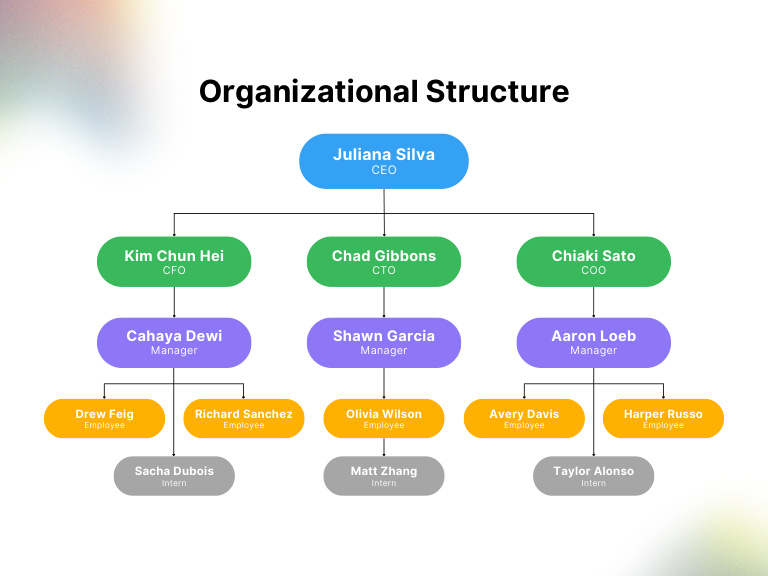

In [18]:
# Function to convert a single page PDF page to a JPEG image
def convert_pdf_page_to_jpg(pdf_path: str, output_path: str, page_number=0):
    if not os.path.exists(pdf_path):
        raise FileNotFoundError(f"PDF file not found: {pdf_path}")
    doc = fitz.open(pdf_path)
    page = doc.load_page(page_number)  # 0 is the first page
    pix = page.get_pixmap()
    # Save the pixmap as a JPEG
    pix.save(output_path)


def display_img_local(image_path: str):
    img = Image.open(image_path)
    display(img)


pdf_path = 'org-chart-sample.pdf'
output_path = 'org-chart-sample.jpg'

convert_pdf_page_to_jpg(pdf_path, output_path)
display_img_local(output_path)

In [21]:
base64_img = encode_image(output_path)

class RoleEnum(str, Enum):
    """Defines possible roles within an organization."""
    CEO = "CEO"
    CTO = "CTO"
    CFO = "CFO"
    COO = "COO"
    EMPLOYEE = "Employee"
    MANAGER = "Manager"
    INTERN = "Intern"
    OTHER = "Other"

class Employee(BaseModel):
    """Represents an employee, including their name, role, and optional manager information."""
    employee_name: str = Field(..., description="The name of the employee")
    role: RoleEnum = Field(..., description="The role of the employee")
    manager_name: Optional[str] = Field(None, description="The manager's name, if applicable")
    manager_role: Optional[RoleEnum] = Field(None, description="The manager's role, if applicable")


class EmployeeList(BaseModel):
    """A list of employees within the organizational structure."""
    employees: List[Employee] = Field(..., description="A list of employees")

def parse_orgchart(base64_img: str) -> EmployeeList:
    response = instructor.from_openai(client).chat.completions.create(
        model='gpt-4-turbo',
        response_model=EmployeeList,
        messages=[
            {
                "role": "user",
                "content": 'Analyze the given organizational chart and very carefully extract the information.',
            },
            {
                "role": "user",
                "content": [
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{base64_img}"
                        }
                    },
                ],
            }
        ],
    )
    return response

In [22]:
# call the functions to analyze the organizational chart and parse the response
result = parse_orgchart(base64_img)

# tabulate the extracted data
df = pd.DataFrame([{
    'employee_name': employee.employee_name,
    'role': employee.role.value,
    'manager_name': employee.manager_name,
    'manager_role': employee.manager_role.value if employee.manager_role else None
} for employee in result.employees])

display(df)

,employee_name,role,manager_name,manager_role
0,Juliana Silva,CEO,None,None
1,Kim Chun Hei,CFO,Juliana Silva,CEO
2,Chad Gibbons,CTO,Juliana Silva,CEO
3,Chiaki Sato,COO,Juliana Silva,CEO
4,Cahaya Dewi,Manager,Kim Chun Hei,CFO
5,Shawn Garcia,Manager,Chad Gibbons,CTO
6,Aaron Loeb,Manager,Chiaki Sato,COO
7,Drew Feig,Employee,Cahaya Dewi,Manager
8,Richard Sanchez,Employee,Cahaya Dewi,Manager
9,Olivia Wilson,Employee,Shawn Garcia,Manager
